In [ ]:
#!pip install -r requirements.txt
import numpy as np 
import pandas as pd
from sklearn.preprocessing import StandardScaler

In [ ]:
f = "data/tcga_brca_all_clean.csv.zip"

#TODO slide_id -> file path 

## Preprocessing genomic data 

In [ ]:
n_bins = 4
df = pd.read_csv(f,compression='zip')

df_uncensored = (df[df["censorship"]==0]).drop_duplicates(["case_id"])
_,bins = pd.qcut(df_uncensored['survival_months'],q = n_bins,retbins=True)  # distribute censored survival months into quartiles

# adapt bins 
bins[0] = 0 
bins[-1] = np.inf
#
labels=[i for i in range(n_bins)]
labels

df.insert(6,"survival_months_discretized",  pd.cut(df["survival_months"],
                                                               bins=bins, 
                                                               labels=labels)) # insert binned survival momnth 
k = 7
df.insert(3,"kfold",df.index%k) # insert kfold 
df.head(5)

scale genomic data first and store in DF again
then add labels to stratify 

In [ ]:
# todo add new column k-th-fold that contains an int in arange(k) where k is a cluster 
groundtruth = df["survival_months_discretized"]
censorship = df["censorship"]
genomics = df[df.keys()[11:]]
genomics


In [ ]:


scaler = StandardScaler()
scaled_genomics = scaler.fit_transform(genomics)
#scaler.inverse_transform(scaled_genomics)
df_scaled = df.copy()
df_scaled[df.keys()[11:]] = scaled_genomics



###  This leads to the full function:

In [ ]:
def clean2trainable(df_path,k,n_bins=4,savename = None):
    df = pd.read_csv(df_path,compression='zip')

    # get time bins 
    df_uncensored = (df[df["censorship"]==0]).drop_duplicates(["case_id"])
    _,bins = pd.qcut(df_uncensored['survival_months'],q = n_bins,retbins=True)  # distribute censored survival months into quartiles

    # adapt time bins 
    bins[0] = 0 
    bins[-1] = np.inf
    # bin name = index 
    labels = [i for i in range(n_bins)]
    df.insert(6,"survival_months_discretized",  pd.cut(df["survival_months"],
                                                               bins=bins, 
                                                               labels=labels)) # insert binned survival month 
    diction = dict([(name,idx) for idx,name in enumerate(df["case_id"].unique()) ])
    df.insert(3,"kfold",df["case_id"].map(diction)%kfolds) # insert kfold 

    genomics = df[df.keys()[11:]]

    scaler = StandardScaler()
    scaled_genomics = scaler.fit_transform(genomics)
    df[df.keys()[11:]] = scaled_genomics

    if savename is not None:
        df.to_csv(savename,index=False)
    return df 

In [ ]:
f = "data/tcga_brca_all_clean.csv.zip"
new_df = clean2trainable(f,5,4,savename = "./data/tcga_brca_trainable.csv")
#new_df = clean2trainable(f,7,4)

In [ ]:
f_new = "data/tcga_brca_trainable.csv"
df = pd.read_csv(f_new)
df.head()

In [ ]:
df[df.keys()[11:]].head()

## k-Fold crossvalidation
1. Cluster dataset into k groups (shuffle first(seeded) then stratify by patient,split into equal chunks)
2. use one group for testing and the others for training
3. rotate such that each group is once used for testing
4. use distribution of testing results to estimate real value 



In [ ]:
k = 7 
a = np.arange(k) # df k-th fold 
for i in range(k):  
    a = (a+1)%k
    print(f"train on {a[:-1]} test on {a[-1]}, store results in foldername: experiment1_fold{a[-1]}")



In [ ]:
df = pd.DataFrame({"col1": np.arange(100),"col2":np.random.rand(100)})
df
df["col1"] = df["col1"].apply(lambda x: f"thisis{x}")
df

In [ ]:
f = "data/tcga_brca_all_clean.csv.zip"
f = f.replace("all_clean.csv.zip","trainable.csv")
f

In [ ]:
!pip install torchmetrics


In [ ]:
import torch 
idx = torch.randint(low=0,high=4,size=(100,))
values = torch.zeros(size=(100,4))
source = torch.ones(size=(100,))

In [ ]:
values.scatter_(dim=1,index=idx,src=source)

In [ ]:
groundtruth = torch.zeros(size=(10,4))
a,b = groundtruth.size()
labels = torch.randint(low=0,high=b,size=(1,a))
groundtruth[torch.arange(a),labels]=1
groundtruth

In [ ]:
from torchmetrics import Accuracy
acc = Accuracy("multiclass")

In [ ]:
a = torch.randint(low=0,high=2,size=(100,))
a



In [ ]:

from sksurv.metrics import concordance_index_censored
c = torch.randint(0,2,size=(100,))
l = torch.randint(0,4,size=(100,))
out = nn.Sigmoid()(torch.rand(size=(100,4)))
c_index = concordance_index_censored(c,l,out)


## Transformer 


In [ ]:
import torch 
from torch import nn 

class Classifier_Head(nn.Module):
    def __init__(self,outsize,d_hidden=256,t_bins=4):
        super(Classifier_Head,self).__init__()

        self.linear1 = nn.Linear(outsize,d_hidden)
        torch.nn.init.kaiming_normal_(self.linear1.weight)
        self.activ1 = nn.ReLU()
        self.linear2  = nn.Linear(d_hidden,d_hidden)
        torch.nn.init.kaiming_normal_(self.linear2.weight)
        self.activ2 = nn.ReLU()
        self.fc = nn.Linear(d_hidden,t_bins) # TODO test add layer
    def forward(self,x):
        x = torch.flatten(x,start_dim=1)
        x = self.activ1(self.linear1(x))
        x = self.activ2(self.linear2(x))
        return self.fc(x)

class Attention_surv(nn.Module):
    def __init__(self,hist_dim,bins):
        super(Attention_surv,self).__init__()
        self.mhsa = nn.MultiheadAttention(hist_dim,num_heads=4,dropout=0.3,batch_first=True)
        self.head = Classifier_Head(hist_dim,t_bins = bins)
    def forward(self,hist):
        attn_output, attn_output_weights = self.mhsa(hist,hist,hist)
        attn_output = attn_output.mean(dim=1)
        return self.head(attn_output)



In [ ]:
from multi_modal_ds import HistGen_Dataset
import pandas as pd
from utils import Survival_Loss
alpha = 0.25
bins = 4
lr = 2e-4
l1_lambda = 1e-5

f = f"/nodes/bevog/work4/seibel/data/tcga_brca_trainable{bins}.csv"
device = 'cuda' if torch.cuda.is_available() else 'cpu'
data_path = "/nodes/bevog/work4/seibel/data/TCGA-BRCA-DX-features/tcga_brca_20x_features/pt_files" # folderpath for h5y fiels which contain the WSI feat vecs 
batchsize = 1  # due to different size of bags 

df = pd.read_csv(f)
train_ds = HistGen_Dataset(df,data_path = data_path,train=True)
test_ds = HistGen_Dataset(df,data_path = data_path,train=False)
training_dataloader = torch.utils.data.DataLoader( train_ds,batch_size=batchsize)
test_dataloader = torch.utils.data.DataLoader(test_ds,batch_size=batchsize)


model = Attention_surv(hist_dim=2048,bins=bins).to(device)
optimizer = torch.optim.Adam(model.parameters(),lr=lr,betas=[0.9,0.999],weight_decay=1e-5,)
criterion = Survival_Loss(alpha)


In [ ]:
for idx,(histo,gen,c,l,_) in enumerate(training_dataloader):
    histo = histo.to(device)
    out = model(histo)
    out = out.cpu()
    #weights = model.mhsa.parameters()
    loss = criterion(out,c,l) #+ l1_lambda * torch.norm(weights.cpu(),1)
    loss.backward()
    break

# KaplanMeier


In [ ]:
from sksurv.nonparametric import kaplan_meier_estimator
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
bins = 4
f = f"/nodes/bevog/work4/seibel/data/tcga_brca_trainable{bins}.csv"
df = pd.read_csv(f)
df = df[["slide_id","survival_months_discretized","censorship","survival_months"]]

In [ ]:
#help(kaplan_meier_estimator)
event = np.asarray(1-df["censorship"]).astype(bool)
time_exit = np.asarray(df["survival_months"])


x_full, y_full = kaplan_meier_estimator(event, time_exit)
plt.step(x_full, y_full, where="post")
plt.ylim(0, 1.1)
plt.grid()
plt.show


In [ ]:
from models import AttMil_Survival
from multi_modal_ds import HistGen_Dataset
import torch 
from torch import nn 
from utils import c_index
import numpy as np
import pandas as pd
#load model 
d_hist = 2048
device = 'cuda' if torch.cuda.is_available() else 'cpu'
bins = 4
model = AttMil_Survival(d_hist,bins,device ).to(device)
#load weights 
f_weights = "/work4/seibel/results/alpha0.5hist/AttMil_Survival_nll-alpha0.5-fold5-l1_lambda1e-07.pth"
weights = torch.load(f_weights)['model']
model.load_state_dict(weights)



In [ ]:

f =  f"/nodes/bevog/work4/seibel/data/tcga_brca_trainable{bins}.csv"
df = pd.read_csv(f)
data_path = "/nodes/bevog/work4/seibel/data/TCGA-BRCA-DX-features/tcga_brca_20x_features/pt_files" 
test_ds = HistGen_Dataset(df,data_path,train=False)
test_dataloader = torch.utils.data.DataLoader(test_ds,batch_size=1)

out_all_val =torch.empty(size=(len(test_dataloader),bins),device='cpu')        
l_all_val = torch.empty(size=(len(test_dataloader),),device='cpu').to(torch.int16)
l_cont_all_val = torch.empty(size=(len(test_dataloader),),device='cpu').to(torch.int16)
c_all_val = torch.empty(size=(len(test_dataloader),),device='cpu').to(torch.int16)

model.eval()
with torch.no_grad():
    for  idx,(histo,gen,c,l,l_cont) in enumerate(test_dataloader):
        x = histo.to(device)
        out = model(x)
        out = out.cpu()
        
        out_all_val[idx,:] = out
        l_all_val[idx] = l
        c_all_val[idx] = c
        l_cont_all_val[idx] = l_cont

h = nn.Sigmoid()(out_all_val)
S = torch.cumprod(1-h,dim = -1)
risk = -S.sum(dim=1) ## TODO why is it not 1-S ???




In [ ]:
from utils import c_index
import matplotlib.pyplot as plt

c_ind = c_index(out_all_val,c_all_val,l_all_val)
plt.title(f"risk distribution with c_index= {round(c_ind,3)}")
plt.hist(risk.numpy(),bins = 100)
plt.show()
test_ds.gen_depth()

In [ ]:
rows = 4 
eps=0.1
threshold = np.linspace(risk.min()+eps,risk.max()-eps,num=12)
fig,ax1 = plt.subplots(rows,len(threshold)//rows,figsize=(24,8))
fig.tight_layout()
for i in range(len(threshold)):
    risk_bool = risk>threshold[i]
    event1 = np.asarray(1-c_all_val[risk_bool]).astype(bool)
    time_exit1 = np.asarray(l_cont_all_val[risk_bool])
    x1, y1 = kaplan_meier_estimator(event1, time_exit1)

    event2 = np.asarray(1-c_all_val[~risk_bool]).astype(bool)
    time_exit2 = np.asarray(l_cont_all_val[~risk_bool])
    x2, y2 = kaplan_meier_estimator(event2, time_exit2)
    
    x_full, y_full = kaplan_meier_estimator(event, time_exit)

    ax1.flatten()[i].set_title(f"KM for threshold {round(threshold[i],3)}")
    ax1.flatten()[i].step(x1, y1, where="post",label="high risk")
    ax1.flatten()[i].step(x2, y2, where="post",label="low risk")
    ax1.flatten()[i].step(x_full, y_full, where="post",label="full KM")
    
    ax1.flatten()[i].set_ylim(0, 1.1)
    ax1.flatten()[i].grid()
    ax1.flatten()[i].legend()


#plt.clf
#plt.title(f"KM for threshold {round(threshold[i])}")
#plt.step(x1, y1, where="post",label="high risk")
#plt.step(x2, y2, where="post",label="low risk")
#plt.ylim(0, 1.1)
#plt.grid()
#plt.legend()
#plt.show

In [ ]:
plt.title("Scatter risk vs survival month")
plt.scatter(risk[c_all_val.type(torch.bool)],l_cont_all_val[c_all_val.type(torch.bool)],s = 4,label="censored")
plt.scatter(risk[~(c_all_val.type(torch.bool))],l_cont_all_val[~(c_all_val.type(torch.bool))],s = 4,label="uncensored")
plt.xlabel("Risk score")
plt.ylabel("Survival month")
plt.legend()
plt.grid()

In [ ]:
plt.clf()
plt.title(f"risk distribution")
plt.hist(risk[c_all_val.type(torch.bool)].numpy(),bins = 30,alpha=0.5,label="a")
plt.hist(risk[~(c_all_val.type(torch.bool))].numpy(),bins = 30,alpha=0.5,label="b")
plt.legend()
plt.show()

In [ ]:
import wandb
import matplotlib.pyplot as plt 
wandb.init(project="MultiModal",entity="tobias-seibel",name="tests")
out_all_val = out_all_val
n_thresholds = 4
nbins = 30
c_all_val = c_all_val
l_cont_all_val = l_cont_all_val 

#risk
def get_risk(out):
    h = nn.Sigmoid()(out)
    S = torch.cumprod(1-h,dim = -1)
    risk = -S.sum(dim=1)
    return risk
risk_all = get_risk(out_all_val)

#thresholds
min,max = risk_all.min(),risk_all.max()
thresholds = torch.linspace(min,max,n_thresholds+2)[1:-1]

#hist 
censored = c_all_val.type(torch.bool)
uncensored = ~c_all_val.type(torch.bool)

x_c1 = torch.histc(risk_all[censored],bins=nbins,min = min , max =max ) 
x1_label = torch.ones_like(x_c1)
x_c2 = torch.histc(risk_all[uncensored],bins=nbins,min = min , max =max ) 
x2_label = torch.zeros_like(x_c2)
x_all = torch.stack((x_c1,x_c2)).T


#table = wandb.Table(data = x_all.tolist(),columns=["censored","uncensored"])
table = wandb.plot.line_series(
          xs =np.linspace(min,max,nbins),
          ys=[x_c1,x_c2],
          keys=["censored", "uncensored"],
          title=f"Histogramm",
          xname="risk")
wandb.log({"custom":table})
#KM

#stepfunction
def stepfunc(x,y,eps=1e-4):
    x = np.stack((x-eps,x),axis=1).flatten()
    y = np.stack((y,y),axis=1).flatten()
    return x[1:].copy(),y[:-1].copy()








for idx,threshold in enumerate(thresholds.tolist()): #thresholds
    x_full, y_full = kaplan_meier_estimator(uncensored.numpy(), l_cont_all_val)

    xlow, ylow = kaplan_meier_estimator(uncensored[risk>threshold].numpy(),
                                l_cont_all_val[risk>threshold].numpy())

    xhigh, yhigh = kaplan_meier_estimator(uncensored[risk<=threshold].numpy(),
                                l_cont_all_val[risk<=threshold].numpy())
    
    xfull, yfull = stepfunc(x_full, y_full)
    xlow, ylow =stepfunc(xlow, ylow)
    xhigh, yhigh =stepfunc(xhigh, yhigh)

    #x,y1,y2,y3 = KM_table(xlow,ylow,xhigh,yhigh,xfull,yfull,)
    lineseries = wandb.plot.line_series(
          xs=[xlow,xhigh,xfull],
          ys=[ylow,yhigh,yfull],
          keys=["lowrisk", "highrisk","fullrisk"],
          title=f"KM Stratification at risk={str(round(threshold,2)).replace('.',',')}",
          xname="time")
    
    wandb.log({f"KM_{idx}" :lineseries})
    

# Log the table to wandb
wandb.log({"line_series": table})


wandb.finish()

In [ ]:

def KM_table(xlow,ylow,xhigh,yhigh,xfull,yfull,):
    ### get KM curve on same x values... not needed anymore FML
    low_all = np.stack((xlow,ylow,np.empty_like(ylow)*np.nan,np.empty_like(ylow)*np.nan),1)
    high_all = np.stack((xhigh,np.empty_like(yhigh)*np.nan,yhigh,np.empty_like(yhigh)*np.nan),1)
    full_all = np.stack((xfull,np.empty_like(yfull)*np.nan,np.empty_like(yfull)*np.nan, yfull),1)
    all = np.concatenate((low_all,high_all,full_all),axis=0)

    all = all[all[:, 0].argsort()] # sort by first element 

    for i in range(1,len(all)):
        a = all[i-1,1:] # =:prev-line
        b = all[i,1:]  # =:line
        all[i,1:] = np.where(np.isnan(b),a,b)
        if all[i,0]==all[i-1,0]: #if on same x give info to line, set x of prev-line to nan
            all[i-1,0] = np.nan
            
    all = all[all[:, 0].argsort()]
    all = all[~np.isnan(all[:,0])]
    return all[:,0],all[:,1],all[:,2],all[:,3]  # x, y_low,y_high,y_full



## Final FUnctions for Utils 

In [ ]:


def KM_wandb(run,out,c,event_cond,n_thresholds = 4,nbins = 30):
    print("Start Logging KM-Estimators")
    risk = get_risk(out)
    
    #thresholds
    min,max = risk.min(),risk.max()
    thresholds = np.linspace(min,max,n_thresholds+2)[1:-1]
    
    #hist
    censored = c.type(torch.bool)
    uncensored = ~c.type(torch.bool)
    
    hist_censored = torch.histc(risk[censored],bins=nbins,min = min , max =max ) 
    hist_uncensored = torch.histc(risk[uncensored],bins=nbins,min = min , max =max ) 
    
    table = run.plot.line_series(
          xs =np.linspace(min,max,nbins),
          ys=[hist_censored,hist_uncensored],
          keys=["censored", "uncensored"],
          title=f"Histogramm",
          xname="risk")
    run.log({"risk_histogramm":table})
    
    #KaplanMeier Plots
    x_full, y_full = kaplan_meier_estimator(uncensored.numpy(), event_cond)
    xfull, yfull = stepfunc(x_full, y_full)
    for idx,threshold in enumerate(thresholds): 
        xlow, ylow = kaplan_meier_estimator(uncensored[risk>threshold].numpy(),
                                    event_cond[risk>threshold])

        xhigh, yhigh = kaplan_meier_estimator(uncensored[risk<=threshold].numpy(),
                                    event_cond[risk<=threshold])
        
        xlow, ylow =stepfunc(xlow, ylow)
        xhigh, yhigh =stepfunc(xhigh, yhigh)

        
        lineseries = run.plot.line_series(
            xs=[xlow,xhigh,xfull],
            ys=[ylow,yhigh,yfull],
            keys=["lowrisk", "highrisk","fullrisk"],
            title=f"KM Stratification at risk={str(round(threshold,2)).replace('.',',')}",
            xname="time")
        
        run.log({f"KM_{idx}" :lineseries})
    print("Finished logging KM-Estimators")
    
def get_risk(out):
    h = nn.Sigmoid()(out)
    S = torch.cumprod(1-h,dim = -1)
    risk = -S.sum(dim=1)
    return risk

def stepfunc(x,y,eps=1e-4):
    x = np.stack((x-eps,x),axis=1).flatten()
    y = np.stack((y,y),axis=1).flatten()
    return x[1:],y[:-1]

def do_table(x,y,label):
    return [[x[i],y[i],label] for i in range(len(x))]

In [ ]:
import wandb
import matplotlib.pyplot as plt 
wandb.init(project="MultiModal",entity="tobias-seibel",name="tests")
out_all_val = out_all_val
n_thresholds = 4
nbins = 30
c_all_val = c_all_val
l_cont_all_val = l_cont_all_val 

#risk
def get_risk(out):
    h = nn.Sigmoid()(out)
    S = torch.cumprod(1-h,dim = -1)
    risk = -S.sum(dim=1)
    return risk
risk_all = get_risk(out_all_val)

#thresholds
min,max = risk_all.min(),risk_all.max()
thresholds = torch.linspace(min,max,n_thresholds+2)[1:-1]

#hist 
censored = c_all_val.type(torch.bool)
uncensored = ~c_all_val.type(torch.bool)

x_c1 = torch.histc(risk_all[censored],bins=nbins,min = min , max =max ).numpy()
x1_label = np.chararray(np.shape(x_c1))
x1_label[:]="censored"
x_c2 = torch.histc(risk_all[uncensored],bins=nbins,min = min , max =max ).numpy() 
x2_label = np.chararray(np.shape(x_c2))
x2_label[:]="uncensored"

x1 = np.stack((np.linspace(min,max,nbins),x_c1,x1_label))
x2 = np.stack((np.linspace(min,max,nbins),x_c2,x2_label))
np.concatenate((x1,x2),dim=1).T

table = wandb.Table(
          data = np.concatenate((x1,x2),dim=1).T,
          columns=["bins", "risk","category"],
          
          

          )
wandb.log({"custom":table})
#KM

wandb.finish()


## Better version for custom plots! 

In [ ]:

x = np.linspace(min,max,nbins)
x_c1 = torch.histc(risk_all[censored],bins=nbins,min = min , max =max ).numpy()
x_c2 = torch.histc(risk_all[uncensored],bins=nbins,min = min , max =max ).numpy() 

table_hist = wandb.Table(
          data = do_table(x,x_c1,"censored")+do_table(x,x_c2,"uncensored"),
          columns=["risk", "count","category"],
          )

fields_hist = {"x":"risk","y":"count","groupKeys":"category","title":"Risk Distribution"}
custom_histogram = wandb.plot_table(vega_spec_name="tobias-seibel/risk_distribution",
              data_table=table_hist,
              fields = fields_hist )
              
              
event_cond = l_cont_all_val
threshold = -2
xfull, yfull = kaplan_meier_estimator(uncensored.numpy(), event_cond)

xlow, ylow = kaplan_meier_estimator(uncensored[risk>threshold].numpy(),
                                    event_cond[risk>threshold])

xhigh, yhigh = kaplan_meier_estimator(uncensored[risk<=threshold].numpy(),
                                    event_cond[risk<=threshold])
        


table_KM = wandb.Table(
          data = do_table(xlow,ylow,"low risk group")+do_table(xhigh,yhigh,"risk high group")+do_table(xfull,yfull,"total group"),
          columns=["time","Survival Probability","Group"],)

field_KM = {"x":"time","y":"Survival Probability","groupKeys":"Group"}
custom_KM = wandb.plot_table(vega_spec_name="tobias-seibel/kaplanmeier",
              data_table=table_KM,
              fields = field_KM, 
              string_fields={"title":f"KM Risk Stratification at {round(threshold,2)}"},
              )

wandb.init()

idx = 1 
wandb.log({"Risk Distribution":custom_histogram,"KM{idx}":custom_KM}) #tobias-seibel/risk_distribution # tobias-seibel/kaplanmeier
wandb.finish()


In [ ]:
def KM_wandb(run,out,c,event_cond,n_thresholds = 4,nbins = 30):
    print("Start Logging KM-Estimators")
    risk = get_risk(out)
    
    #thresholds
    min,max = risk.min(),risk.max()
    thresholds = np.linspace(min,max,n_thresholds+2)[1:-1]
    
    #hist
    censored = c.type(torch.bool)
    uncensored = ~c.type(torch.bool)
    
    ###wandb histogram
    x = np.linspace(min,max,nbins)
    x_c1 = torch.histc(risk_all[censored],bins=nbins,min = min , max =max ).numpy()
    x_c2 = torch.histc(risk_all[uncensored],bins=nbins,min = min , max =max ).numpy() 

    table_hist = wandb.Table(
            data = do_table(x,x_c1,"censored")+do_table(x,x_c2,"uncensored"),
            columns=["risk", "count","category"],
            )

    fields_hist = {"x":"risk","y":"count","groupKeys":"category","title":"Risk Distribution"}
    custom_histogram = wandb.plot_table(vega_spec_name="tobias-seibel/risk_distribution",
                data_table=table_hist,
                fields = fields_hist )
    
    wandb.log({"Risk Distribution":custom_histogram})
    ###
    
    
    
    
    #KaplanMeier Plots
    xfull, yfull = kaplan_meier_estimator(uncensored.numpy(), event_cond)
    
    for idx,threshold in enumerate(thresholds): 
        xlow, ylow = kaplan_meier_estimator(uncensored[risk>threshold].numpy(),
                                    event_cond[risk>threshold])

        xhigh, yhigh = kaplan_meier_estimator(uncensored[risk<=threshold].numpy(),
                                    event_cond[risk<=threshold])
        
        
        table_KM = wandb.Table(data = do_table(xlow,ylow,"low risk group")+do_table(xhigh,yhigh,"risk high group")+do_table(xfull,yfull,"total group"),
                        columns=["time","Survival Probability","Group"],)

        field_KM = {"x":"time","y":"Survival Probability","groupKeys":"Group"}
        custom_KM = wandb.plot_table(vega_spec_name="tobias-seibel/kaplanmeier",
                    data_table=table_KM,
                    fields = field_KM, 
                    string_fields={"title":f"KM Risk Stratification at {round(threshold,2)}"},
                    )
        run.log({f"KM_{idx}" :custom_KM})
    print("Finished logging KM-Estimators")
    

In [ ]:
run = wandb.init()
KM_wandb(run,out_all_val,c_all_val,l_cont_all_val,n_thresholds = 4,nbins = 30)
run.finish()

# Transformer 


In [1]:
import torch
from torch import nn
from utils import *
class Classifier_Head(nn.Module):
    def __init__(self,outsize,d_hidden=256,t_bins=4):
        super(Classifier_Head,self).__init__()

        self.linear1 = nn.Linear(outsize,d_hidden)
        torch.nn.init.kaiming_normal_(self.linear1.weight)
        self.activ1 = nn.ReLU()
        self.linear2  = nn.Linear(d_hidden,d_hidden)
        torch.nn.init.kaiming_normal_(self.linear2.weight)
        self.activ2 = nn.ReLU()
        self.fc = nn.Linear(d_hidden,t_bins) # TODO test add layer
    def forward(self,x):
        x = torch.flatten(x,start_dim=1)
        x = self.activ1(self.linear1(x))
        x = self.activ2(self.linear2(x))
        return self.fc(x)
    
    
class TransformerMil_Survival(nn.Module):
  def __init__(self,d_seq,d_transformer,bins):
    super(TransformerMil_Survival,self).__init__()
    d_out = d_hidden = 256
    self.lin_embedder1 = nn.Linear(d_seq,d_transformer,dropout)
    #self.Encoder = torch.nn.TransformerEncoder(nn.TransformerEncoderLayer(d_transformer,
    #                                                                 nhead=2,dropout=0.1,activation=nn.GELU(),batch_first=True)
    #                                      ,num_layers=2)
    self.Encoder=nn.TransformerEncoderLayer(d_transformer,nhead=2,dropout=dropout,activation=nn.GELU(),batch_first=True)
    self.lin_embedder2 = nn.Linear(d_transformer,d_out)
    self.Classifier_Head = Classifier_Head(outsize = d_out,d_hidden=d_hidden,t_bins=bins)
  def forward(self,x):
    
    x = self.lin_embedder1(x)
    x = self.Encoder(x)
    out = x.mean(dim=-2)
    out = self.lin_embedder2(out)
    return self.Classifier_Head(out)


/home/seibel/.local/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = "cuda"
bins = 4
model = TransformerMil_Survival(d_seq=2048,d_transformer=1024,bins=bins)
model.to(device)


criterion = Survival_Loss(0.25) 
optimizer = torch.optim.Adam(model.parameters(),lr=0.00003,betas=[0.9,0.999],weight_decay=1e-5,)

In [3]:
nseq = 15000
B=1
dims = 2048

x = torch.rand(size=(B,nseq,dims)).to(device)
l = torch.randint(low=0, high=bins, size=(B,)).to(device)
c = torch.randint(low=0, high=2, size=(B,)).to(device)  ## Groundtruth boolean information wether the the patient is censored  c = 1 or uncensored  

out = model(x)
loss = criterion(out,c,l)
loss.backward()

RuntimeError: CUDA out of memory. Tried to allocate 1.68 GiB (GPU 0; 10.92 GiB total capacity; 10.02 GiB already allocated; 60.69 MiB free; 10.06 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [36]:
df

,case_id,slide_id,site,kfold,is_female,oncotree_code,age,survival_months_discretized,survival_months,censorship,train
0,TCGA-3C-AALI,TCGA-3C-AALI-01Z-00-DX1.F6E9A5DF-D8FB-45CF-B4B...,3C,0,1.0,IDC,50.0,3,131.57,1.0,1.0
1,TCGA-3C-AALI,TCGA-3C-AALI-01Z-00-DX2.CF4496E0-AB52-4F3E-BDF...,3C,0,1.0,IDC,50.0,3,131.57,1.0,1.0
2,TCGA-3C-AALJ,TCGA-3C-AALJ-01Z-00-DX1.777C0957-255A-42F0-9EE...,3C,1,1.0,IDC,62.0,2,48.42,1.0,1.0
3,TCGA-3C-AALJ,TCGA-3C-AALJ-01Z-00-DX2.62DFE56B-B84C-40F9-962...,3C,1,1.0,IDC,62.0,2,48.42,1.0,1.0
4,TCGA-3C-AALK,TCGA-3C-AALK-01Z-00-DX1.4E6EB156-BB19-410F-878...,3C,2,1.0,IDC,52.0,2,47.57,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
1018,TCGA-WT-AB44,TCGA-WT-AB44-01Z-00-DX1.B6ECEA7C-DA26-4B34-88C...,WT,2,1.0,ILC,77.0,1,29.01,1.0,1.0
1019,TCGA-XX-A899,TCGA-XX-A899-01Z-00-DX1.08FE27B7-73B8-4CE3-ACF...,XX,3,1.0,ILC,46.0,0,15.34,1.0,1.0
1020,TCGA-XX-A89A,TCGA-XX-A89A-01Z-00-DX1.671E2AD6-4D1A-4579-88C...,XX,4,1.0,ILC,68.0,0,16.03,1.0,1.0
1021,TCGA-Z7-A8R5,TCGA-Z7-A8R5-01Z-00-DX1.3BDB407F-514C-4131-B05...,Z7,0,1.0,ILC,61.0,3,107.98,1.0,1.0


In [34]:
#import numpy as np 
kfold=5
names = df["case_id"].unique()

diction = dict([(name,idx) for idx,name in enumerate(df["case_id"].unique()) ])
df["kfold"] = df["case_id"].map(diction)%kfold

In [35]:

df["kfold"]

0       0
1       0
2       1
3       1
4       2
       ..
1018    2
1019    3
1020    4
1021    0
1022    1
Name: kfold, Length: 1023, dtype: int64

In [3]:
import torch
torch.empty(())

tensor(6.2703e+22)

# Check lossfunction behaviour

In [3]:
from utils.Aggregation_Utils import Survival_Loss
import torch
lossfunc = Survival_Loss(alpha=0.25)

In [24]:
out = 4*(torch.rand((1,4))+torch.tensor([0,0,0,3]))
linlayer = torch.nn.Linear(4,4)
c = torch.tensor([1])
t = torch.tensor([3])
linlayer.zero_grad()
loss = lossfunc(linlayer(out),c,t)
loss.backward()

for name,param in linlayer.named_parameters():
    if param.grad is not None:
        print(f"Parameter: {name}, Gradient: {list(param.grad.flatten().numpy())}")

Parameter: weight, Gradient: [0.08905183, 0.04643555, 0.08748735, 0.4163526, 2.1671782, 1.1300622, 2.1291046, 10.132417, 1.4594525, 0.76102287, 1.4338125, 6.823519, 0.0021104203, 0.0011004662, 0.002073344, 0.009867052]
Parameter: bias, Gradient: [0.03080241, 0.7496119, 0.5048145, 0.0007299798]


In [308]:
import torch
from utils.Aggregation_Utils import Survival_Loss
def improvedout(out,c,t,alpha,fac,tanapproach=False):
    lossfunc = Survival_Loss(alpha=alpha)
    optimizer = torch.optim.AdamW([out],lr=0.01)
    loss_vec = []
    for i in range(1000):
        optimizer.zero_grad()
        if tanapproach:
            x = torch.arange(out.size(-1)).unsqueeze(0).repeat(out.size(0),1)
            target = torch.tanh(x-t.unsqueeze(1))-alpha*c.unsqueeze(-1).repeat(1,x.size(-1))
            loss = torch.nn.MSELoss()(out,target)
        else:
            loss = lossfunc(out,c,t)
        loss_vec.append(loss.detach().item())
        
        # Compute gradients
        loss.backward()
        optimizer.step()    
    return out ,loss_vec
    

In [309]:
bins = 8
alpha=0.5
n_censored = 20
n_uncensored = 2
    
loss_vec_all = []
risks_list = []
outvals = []
for i in range(bins):
    
    randi= torch.cat((0.01+torch.rand((n_censored,bins)),torch.rand((n_uncensored,bins))),dim=0)
    out = (randi.clone().detach()).requires_grad_(True)
    #out = torch.cumsum(out,dim=1).requires_grad_(True)
    c = torch.tensor([item for sublist in [[0]*n_uncensored,[1]*n_censored] for item in sublist])
    t = torch.tensor([item for sublist in [[i]*n_uncensored,[i]*n_censored] for item in sublist])
    outputval,loss_vec = improvedout(out,c,t,alpha,fac=i,tanapproach=True)
    loss_vec_all.append(loss_vec)
    h = torch.nn.Sigmoid()(outputval)
    S = torch.cumprod(1-h,dim = -1)
    #risk = torch.exp(-S.sum(dim=1))
    risk = -S.sum(dim=1)
    risks_list.append(risk.detach().numpy())
    outvals.append(outputval.detach().numpy())
    #print("i :",i,"risk :",risk.detach().numpy())


<function matplotlib.pyplot.show(close=None, block=None)>

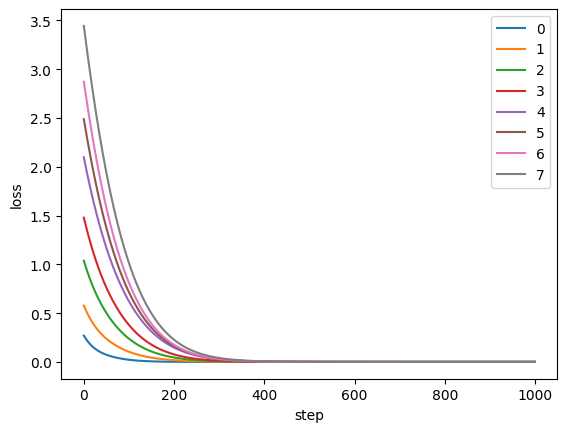

In [310]:
import matplotlib.pyplot as plt
plt.clf()
for j in range(len(loss_vec_all)):
    plt.plot(loss_vec_all[j],label=str(j))
plt.legend()
plt.xlabel("step")
plt.ylabel("loss")
#plt.yscale("log")
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

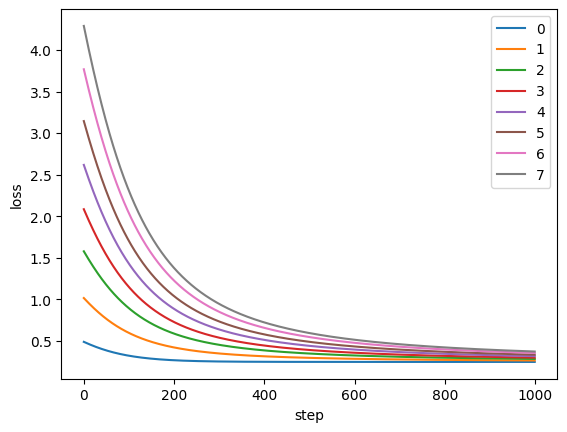

In [289]:
import matplotlib.pyplot as plt
plt.clf()
for j in range(len(loss_vec_all)):
    plt.plot(loss_vec_all[j],label=str(j))
plt.legend()
plt.xlabel("step")
plt.ylabel("loss")
#plt.yscale("log")
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

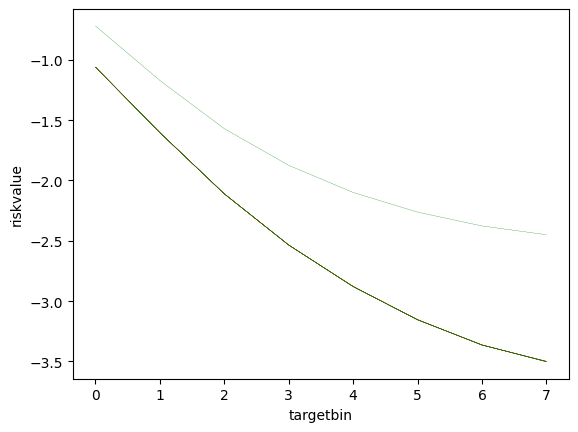

In [311]:
plt.clf()
for j in range(n_censored+n_uncensored):
    plt.plot([risks[j] for risks in risks_list],color=f"green" if j<n_censored else f"red",linewidth=0.1)
plt.xlabel("targetbin")
plt.ylabel("riskvalue")
#plt.yscale("log")
plt.show

In [276]:
[0]*6

[0, 0, 0, 0, 0, 0]

In [312]:
import numpy as np
a = torch.tensor(np.array(outvals)) # target, n_censored+n_uncensored, bins


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


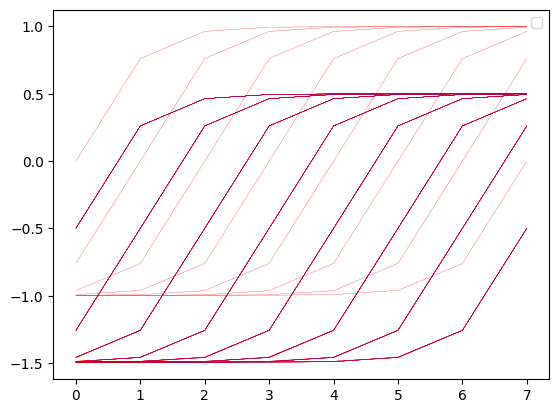

In [313]:
plt.clf()
for i in range(bins):
    for j in range(n_censored+n_uncensored):
        label = "uncensored" if j<n_censored else "censored"
        col = "red" if j<n_censored else "blue"
        #col = "red" if i==0 else "green" if i==1 else "yellow" if i==2 else "blue"
        plt.plot(a[i,j,:],linewidth=0.1,color=col)
plt.legend()
plt.show()

In [17]:
import os
import h5py
import torch
path = "/nodes/bevog/work4/seibel/data/TCGA-BRCA-DX-features/vit_mae_tiny_I1K_PT_TCGA_BRCA_FT_HIST_GEN_119eps_features/pt_files"
#path = "/nodes/bevog/work4/seibel/data/TCGA-BRCA-DX-features/vit_mae_tiny_I1K_PT_FT_50eps_TCGA_BRCA_features/pt_files"
#path = "/nodes/bevog/work4/seibel/data/TCGA-BRCA-DX-features/vit_mae_tiny_I1K_PT_FT_50eps_TCGA_BRCA_features/pt_files"
names = os.listdir(path)
tensors= []
for i in range(len(names)):
    tensor_path =os.path.join(path, names[i]) 
    tensor_file =h5py.File(tensor_path, "r")
    tensor_file = torch.tensor(tensor_file["feats"][:]).to(torch.float32)
    tensors.append(tensor_file)
    
tensors = torch.cat(tensors)
tensors.size()

torch.Size([2701971, 384])

In [18]:
tensors.isnan().any().item()

True

In [28]:
row


max tensor(2.6230) tensor(nan)
max tensor(-1.4775) tensor(nan)


In [27]:
tensors[:][192:].size()

torch.Size([2701779, 384])

In [9]:
import torch 
import pandas as pd
from torch.utils.data import Dataset,DataLoader
import  pytorch_lightning as pl
from utils.Encoder_Utils import Patient_Tileset
from torchvision import transforms
from models.Encoder_Models import SupViTSurv
mycheckpnt = "/home/seibel/maetiny_ft200eps_brca_histo_gen_cont/epoch=119-step=217080_mycopy.ckpt"
model = SupViTSurv(lr=0.001,nbins=4,alpha=0.25)
model.load_state_dict(torch.load(mycheckpnt)["state_dict"])
df_data_path = "/nodes/bevog/work4/seibel/data/tile_encoder_dataframes/tcga_brca__4bins_trainsplit.csv"
df_tile_slide_path = "/nodes/bevog/work4/seibel/data/tile_encoder_dataframes/DF_TCGA-BRCA-TIILES-NORM.csv"
df_tile_paths = pd.read_csv(df_tile_slide_path) 

transform = transform = transforms.Compose([transforms.ToTensor(),
                                            transforms.Normalize(mean=(0.5,0.5,0.5),std=(0.5,0.5,0.5)),
                                            ]
                                        )
slide_name = "TCGA-A2-A3XW-01Z-00-DX1.45F5F36F-5503-4A38-AF37-E526915A8DBE.svs"
idx = 104
df_trainset = pd.read_csv(df_data_path)

genomics_tensor = torch.Tensor(df_trainset[df_trainset.keys()[11:]].to_numpy()).to(torch.float32)
batch_size=128
num_workers=1
pin_memory=False
trainer = pl.Trainer(
        precision="16-mixed",
        accelerator="gpu",
        devices=1,
        detect_anomaly=True
           )
df_tiles = df_tile_paths[df_tile_paths["slide_id"]==slide_name]
gen_vec = genomics_tensor[idx]
dataload_i = DataLoader(Patient_Tileset(df_tiles["tilepath"],gen_vec,transform), batch_size=batch_size,num_workers=num_workers,pin_memory=pin_memory)
#predictions = trainer.predict(model,dataload_i)
#feats = torch.cat(predictions,dim=0)



/home/seibel/.pyenv/versions/3.10.12/envs/env2/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/seibel/.pyenv/versions/3.10.12/envs/env2/lib/p ...
  rank_zero_warn(
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [9]:
outputs = []
model.eval()
for idx,batch  in enumerate(dataload_i):
    x,y = batch 
    with torch.no_grad():
        output = model.predict_step(batch,idx)
        outputs.append(output)
outputs = torch.cat(outputs)

/home/seibel/.pyenv/versions/3.10.12/envs/env2/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/seibel/.pyenv/versions/3.10.12/envs/env2/lib/p ...
  rank_zero_warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/seibel/.pyenv/versions/3.10.12/envs/env2/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:438: PossibleUserWarning: The dataloader, predict_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting DataLoader 0: 100%|██████████| 21/21 [00:10<00:00,  2.06it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|██████████| 21/21 [00:04<00:00,  4.63it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|██████████| 21/21 [00:04<00:00,  4.44it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|██████████| 21/21 [00:04<00:00,  4.55it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|██████████| 21/21 [00:04<00:00,  4.34it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|██████████| 21/21 [00:04<00:00,  4.48it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|██████████| 21/21 [00:04<00:00,  4.53it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|██████████| 21/21 [00:04<00:00,  4.57it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|██████████| 21/21 [00:04<00:00,  4.35it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|██████████| 21/21 [00:04<00:00,  4.27it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|██████████| 21/21 [00:04<00:00,  4.27it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|██████████| 21/21 [00:04<00:00,  4.50it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|██████████| 21/21 [00:04<00:00,  4.48it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|██████████| 21/21 [00:04<00:00,  4.34it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|██████████| 21/21 [00:05<00:00,  4.16it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|██████████| 21/21 [00:05<00:00,  4.17it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

/home/seibel/.pyenv/versions/3.10.12/envs/env2/lib/python3.10/site-packages/pytorch_lightning/trainer/call.py:53: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]
Predicting DataLoader 0: 100%|██████████| 21/21 [00:05<00:00,  4.14it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|██████████| 21/21 [00:04<00:00,  4.45it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0:  86%|████████▌ | 18/21 [00:04<00:00,  4.32it/s]

In [6]:
outputs = trainer.predict(model,dataload_i)
outputs = torch.cat(outputs)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


/home/seibel/.pyenv/versions/3.10.12/envs/env2/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:438: PossibleUserWarning: The dataloader, predict_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting DataLoader 0: 100%|██████████| 21/21 [00:27<00:00,  1.33s/it]


In [10]:
outputs

tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        ...,
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan]])

In [10]:
for name,params in model.named_parameters():
    if params.isnan().any().item():
        print(name)

In [ ]:
pred

False

# Bootstrapping



In [1]:
from models.Aggregation_Models import SNN_Survival
from datasets.Aggregation_DS import Gen_Dataset
import os 
import torch 
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
bins = 4
epochs = 40 
device ='cuda' if  torch.cuda.is_available() else 'cpu'
storepath = None
run_name = "name"
batchsize = 32
d_gen_out = 32
feature_path = "/nodes/bevog/work4/seibel/data/TCGA-BRCA-DX-features/vit_mae_tiny_I1K_PT_FT_50eps_TCGA_BRCA_features/pt_files"
num_workers = 1
csv_path_train = "/nodes/bevog/work4/seibel/data/tile_encoder_dataframes/tcga_brca__4bins_trainsplit.csv"
csv_path_test = "/nodes/bevog/work4/seibel/data/tile_encoder_dataframes/tcga_brca__4bins_testsplit.csv"
csv_path_val = "/nodes/bevog/work4/seibel/data/tile_encoder_dataframes/tcga_brca__4bins_valsplit.csv"

df_train = pd.read_csv(csv_path_train)
df_test = pd.read_csv(csv_path_test)
df_val = pd.read_csv(csv_path_val)

train_ds = Gen_Dataset(df_train,data_path = feature_path,mode="train")
val_ds = Gen_Dataset(df_val,data_path = feature_path,mode="val")
test_ds = Gen_Dataset(df_test,data_path = feature_path,mode="test")

d_gen = train_ds.gen_depth()

model = SNN_Survival(d_gen,d_gen_out,bins,device,activation="SELU").to(device)
training_dataloader = torch.utils.data.DataLoader( train_ds,batch_size=batchsize,num_workers=num_workers,pin_memory=False)
test_dataloader = torch.utils.data.DataLoader(test_ds,batch_size=batchsize,num_workers=num_workers,pin_memory=False)
val_dataloader = torch.utils.data.DataLoader(val_ds,batch_size=batchsize,num_workers=num_workers,pin_memory=False)



In [2]:
from trainer.Aggregation_Trainer import Uni_Trainer_sweep
from utils.Aggregation_Utils import Survival_Loss,c_index
run = None 
epochs = 40
storepath = None 
run_name="none"
modality="gen"
learningrate=1e-5
l1_lambda=1e-7
alpha = 0.25


run = None
criterion = Survival_Loss(alpha) 
optimizer = torch.optim.Adam(model.parameters(),lr=learningrate,betas=[0.9,0.999],weight_decay=1e-5,)
model_trained = Uni_Trainer_sweep(run,model,optimizer,criterion,training_dataloader,
                    val_dataloader,bins,epochs,device,storepath,run_name,
                    l1_lambda,modality=modality,batchsize=batchsize,testloader=None
                    )


In [3]:
def bootstrp(out_all,l_all,c_all,l_con_all):
    n_bootstrap = 1000
    c_idxs = []
    for n in range(n_bootstrap):
        idx = torch.randint(0,out_all.size(0),size=(out_all.size(0),))
        c_idxs.append(c_index(out_all[idx],c_all[idx],l_all[idx]))
    #print(c_idxs)
    c_idxs = [idx for idx in c_idxs if idx==idx]
    return c_idxs

In [4]:

def eval(model,modelname,dataloader):
    #init counter
    out_all =torch.empty(size=(0,bins),device='cpu')        
    l_all = torch.empty(size=(0,),device='cpu').to(torch.int16)
    l_con_all = torch.empty(size=(0,),device='cpu').to(torch.int16)
    c_all = torch.empty(size=(0,),device='cpu').to(torch.int16)
    val_r = 0

    model.eval()
    with torch.no_grad():
        for  idx,(x,c,l,l_con) in enumerate(dataloader):
            x = x.to(device)
            out = model(x)
            out = out.cpu()
            #loss = criterion(out,l)  #CE loss
            loss = criterion(out,c,l)  # TODO add loss regularization 
            val_r += loss.item()
            
            out_all = torch.cat((out_all,out),dim=0)
            l_all = torch.cat((l_all,l),dim=0)
            c_all = torch.cat((c_all,c),dim=0)
            l_con_all = torch.cat((l_con_all,l_con),dim=0)
            

    c_idx_full = c_index(out_all,c_all,l_all)
    
    c_idx_bootstrp = bootstrp(out_all,l_all,c_all,l_con_all)
    return c_idx_bootstrp,c_idx_full,c_all

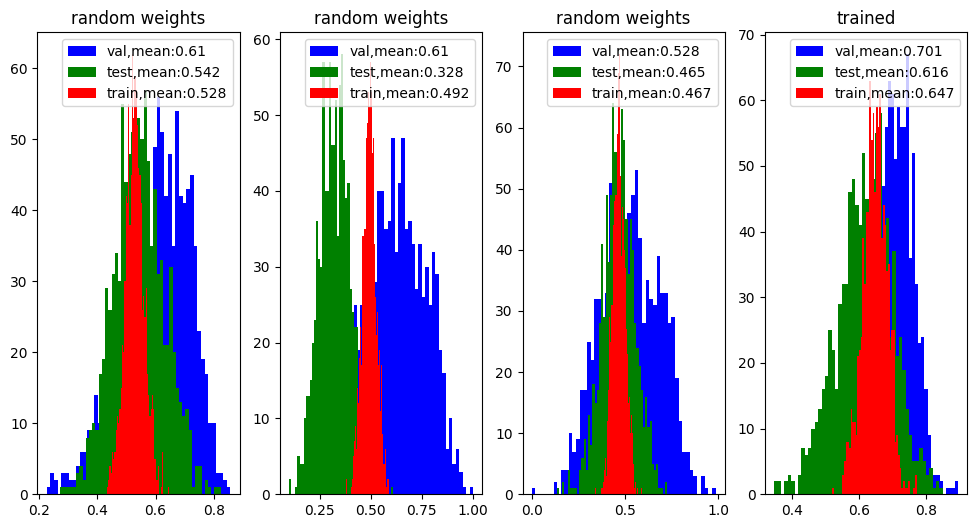

In [7]:
import numpy as np
fig,axis = plt.subplots(1,4,figsize=(12,6))
model1 =  SNN_Survival(d_gen,d_gen_out,bins,device,activation="SELU").to(device)
model2 =  SNN_Survival(d_gen,d_gen_out,bins,device,activation="SELU").to(device)
model3 =  SNN_Survival(d_gen,d_gen_out,bins,device,activation="SELU").to(device)
plt.clf
allmodels = [[model1,"random weights"],
             [model2,"random weights"],
             [model3,"random weights"],
             [model_trained,"trained"],
             ]
for idx,mod in enumerate(allmodels):
    c_idxs1,c_idx_full1,c_train = eval(mod[0],mod[1],training_dataloader)
    c_idxs2,c_idx_full2,c_test = eval(mod[0],mod[1],test_dataloader)
    c_idxs3,c_idx_full3,c_val = eval(mod[0],mod[1],val_dataloader)
    axis[idx].set_title(mod[1])    
    axis[idx].hist(c_idxs3,bins = 50,label = f"val,mean:{round(np.mean(c_idxs3),3)}", color="blue")
    axis[idx].hist(c_idxs2,bins = 50,label = f"test,mean:{round(np.mean(c_idxs2),3)}", color="green")
    axis[idx].hist(c_idxs1,bins = 50,label = f"train,mean:{round(np.mean(c_idxs1),3)}", color="red")
    axis[idx].legend()
plt.show()
#Bootstrap c-index distribution for 3 random and 1 trained model 

In [8]:
train_mean = []
test_mean = []
val_mean = []
train_evaluated = []
test_evaluated = []
val_evaluated = []

for idx in range(100):
    random_model =  SNN_Survival(d_gen,d_gen_out,bins,device,activation="SELU").to(device)
    c_idxs1,c_idx_full1,c_train = eval(random_model,idx,training_dataloader)
    c_idxs2,c_idx_full2,c_test = eval(random_model,idx,test_dataloader)
    c_idxs3,c_idx_full3,c_val = eval(random_model,idx,val_dataloader)
    train_mean.append(np.mean(c_idxs1))
    test_mean.append(np.mean(c_idxs2))
    val_mean.append(np.mean(c_idxs3))
    train_evaluated.append(c_idx_full1)
    test_evaluated.append(c_idx_full2)
    val_evaluated.append(c_idx_full3)





C index problems
C index problems
C index problems
C index problems
C index problems
C index problems
C index problems
C index problems
C index problems
C index problems
C index problems
C index problems
C index problems
C index problems
C index problems
C index problems
C index problems
C index problems
C index problems
C index problems
C index problems
C index problems
C index problems
C index problems
C index problems
C index problems


(array([ 1.,  1.,  0.,  2.,  8.,  4.,  3., 10.,  6.,  8., 10., 14.,  8.,
         7.,  6.,  4.,  4.,  0.,  3.,  1.]),
 array([0.4121761 , 0.42070527, 0.42923444, 0.43776361, 0.44629277,
        0.45482194, 0.46335111, 0.47188028, 0.48040944, 0.48893861,
        0.49746778, 0.50599695, 0.51452611, 0.52305528, 0.53158445,
        0.54011362, 0.54864278, 0.55717195, 0.56570112, 0.57423028,
        0.58275945]),
 <BarContainer object of 20 artists>)

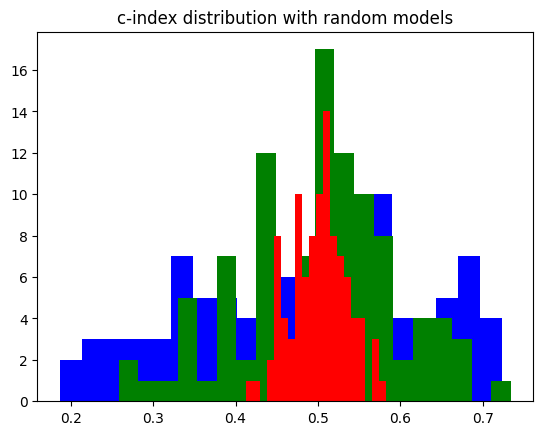

In [97]:
plt.title("c-index distribution with random models")

plt.hist(val_evaluated,bins=20,color = "blue",label="val")
plt.hist(test_evaluated,bins=20,color = "green",label="test")
plt.hist(train_evaluated,bins=20,color = "red",label="train")
plt.show()

In [10]:
import numpy as np 
train_mean = []
test_mean = []
val_mean = []
train_evaluated = []
test_evaluated = []
val_evaluated = []

for idx in range(100):
    random_model =  SNN_Survival(d_gen,d_gen_out,bins,device,activation="SELU").to(device)
    optimizer = torch.optim.Adam(random_model.parameters(),lr=learningrate,betas=[0.9,0.999],weight_decay=1e-5,)
    mod = Uni_Trainer_sweep(run,random_model,optimizer,criterion,training_dataloader,
                    val_dataloader,bins,epochs,device,storepath,run_name,
                    l1_lambda,modality=modality,batchsize=batchsize,testloader=None
                    )
    c_idxs1,c_idx_full1,c_train = eval(mod,idx,training_dataloader)
    c_idxs2,c_idx_full2,c_test = eval(mod,idx,test_dataloader)
    c_idxs3,c_idx_full3,c_val = eval(mod,idx,val_dataloader)
    train_mean.append(np.mean(c_idxs1))
    test_mean.append(np.mean(c_idxs2))
    val_mean.append(np.mean(c_idxs3))
    train_evaluated.append(c_idx_full1)
    test_evaluated.append(c_idx_full2)
    val_evaluated.append(c_idx_full3)

C index problems
C index problems
C index problems
C index problems
C index problems
C index problems
C index problems
C index problems
C index problems
C index problems
C index problems
C index problems
C index problems
C index problems
C index problems


(array([ 1.,  1.,  1.,  0.,  2.,  1.,  4.,  6.,  8.,  8., 14., 10.,  9.,
         8.,  9.,  2.,  4.,  5.,  5.,  2.]),
 array([0.38315603, 0.39383558, 0.40451513, 0.41519467, 0.42587422,
        0.43655377, 0.44723331, 0.45791286, 0.46859241, 0.47927195,
        0.4899515 , 0.50063105, 0.51131059, 0.52199014, 0.53266969,
        0.54334923, 0.55402878, 0.56470833, 0.57538787, 0.58606742,
        0.59674697]),
 <BarContainer object of 20 artists>)

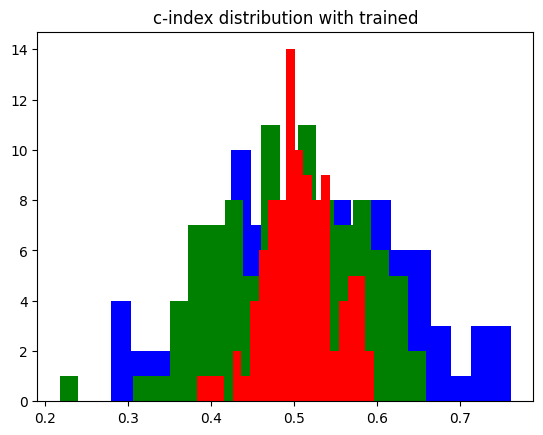

In [ ]:
import matplotlib.pyplot as plt
plt.title("c-index distribution with trained")

plt.hist(val_evaluated,bins=20,color = "blue",label="val")
plt.hist(test_evaluated,bins=20,color = "green",label="test")
plt.hist(train_evaluated,bins=20,color = "red",label="train")

In [ ]:
import numpy as np 
train_mean = []
test_mean = []
val_mean = []
train_evaluated = []
test_evaluated = []
val_evaluated = []

random_init =  SNN_Survival(d_gen,d_gen_out,bins,device,activation="SELU").to(device)

for idx in range(100):
    random_model =  SNN_Survival(d_gen,d_gen_out,bins,device,activation="SELU")
    random_model.load_state_dict(random_init.state_dict())
    random_model.to(device)
    optimizer = torch.optim.Adam(random_model.parameters(),lr=learningrate,betas=[0.9,0.999],weight_decay=1e-5,)
    mod = Uni_Trainer_sweep(run,random_model,optimizer,criterion,training_dataloader,
                    val_dataloader,bins,epochs,device,storepath,run_name,
                    l1_lambda,modality=modality,batchsize=batchsize,testloader=None
                    )
    c_idxs1,c_idx_full1,c_train = eval(mod,idx,training_dataloader)
    c_idxs2,c_idx_full2,c_test = eval(mod,idx,test_dataloader)
    c_idxs3,c_idx_full3,c_val = eval(mod,idx,val_dataloader)
    train_mean.append(np.mean(c_idxs1))
    test_mean.append(np.mean(c_idxs2))
    val_mean.append(np.mean(c_idxs3))
    train_evaluated.append(c_idx_full1)
    test_evaluated.append(c_idx_full2)
    val_evaluated.append(c_idx_full3)

C index problems
C index problems
C index problems
C index problems
C index problems
C index problems
C index problems
C index problems
C index problems
C index problems
C index problems
C index problems
C index problems
C index problems
C index problems
C index problems
C index problems
C index problems
C index problems
C index problems
C index problems
C index problems


(array([ 3.,  2.,  8., 13., 11., 12.,  7.,  6.,  5.,  2.,  5.,  4.,  6.,
         3.,  2.,  4.,  3.,  0.,  3.,  1.]),
 array([0.51453683, 0.52179185, 0.52904687, 0.53630188, 0.5435569 ,
        0.55081192, 0.55806694, 0.56532195, 0.57257697, 0.57983199,
        0.58708701, 0.59434202, 0.60159704, 0.60885206, 0.61610708,
        0.62336209, 0.63061711, 0.63787213, 0.64512715, 0.65238216,
        0.65963718]),
 <BarContainer object of 20 artists>)

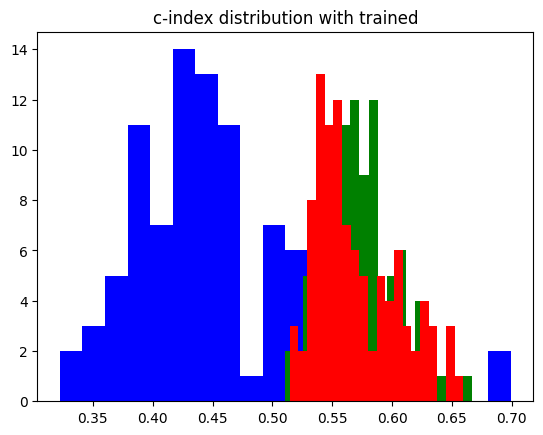

In [ ]:
import matplotlib.pyplot as plt
plt.title("c-index distribution with trained")

plt.hist(val_evaluated,bins=20,color = "blue",label="val")
plt.hist(test_evaluated,bins=20,color = "green",label="test")
plt.hist(train_evaluated,bins=20,color = "red",label="train")

(array([ 4.,  1.,  8., 13., 12., 10.,  9.,  5.,  5.,  2.,  5.,  5.,  6.,
         2.,  5.,  3.,  1.,  2.,  1.,  1.]),
 array([0.51450037, 0.52181032, 0.52912028, 0.53643023, 0.54374019,
        0.55105014, 0.5583601 , 0.56567005, 0.57298001, 0.58028996,
        0.58759992, 0.59490987, 0.60221982, 0.60952978, 0.61683973,
        0.62414969, 0.63145964, 0.6387696 , 0.64607955, 0.65338951,
        0.66069946]),
 <BarContainer object of 20 artists>)

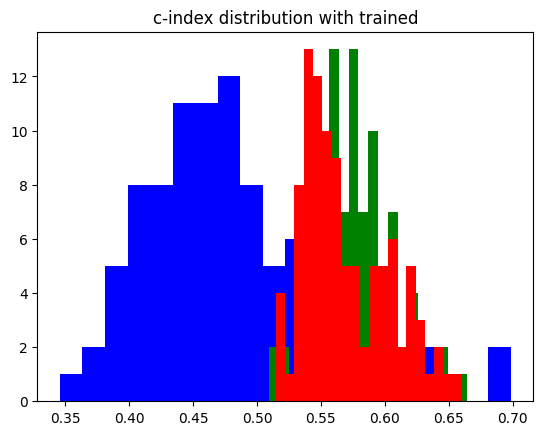

In [10]:
import matplotlib.pyplot as plt
plt.title("c-index distribution with trained")

plt.hist(val_mean,bins=20,color = "blue",label="val")
plt.hist(test_mean,bins=20,color = "green",label="test")
plt.hist(train_mean,bins=20,color = "red",label="train")

In [ ]:
import matplotlib.pyplot as plt
plt.title("c-index distribution with trained")

plt.hist(val_evaluated,bins=20,color = "blue",label="val")
plt.hist(test_evaluated,bins=20,color = "green",label="test")
plt.hist(train_evaluated,bins=20,color = "red",label="train")

In [ ]:
print(f"train: from {len(c_train)}, {c_train.sum()} are censored")
print(f"test: from {len(c_test)}, {c_test.sum()} are censored")
print(f"val: from {len(c_val)}, {c_val.sum()} are censored")

train: from 710, 598 are censored
test: from 208, 194 are censored
val: from 105, 97 are censored


In [1]:
import torch 

a = torch.rand((5,512))
b = torch.rand((4,512))
c = torch.rand((3,512))

d = [a,b,c]
torch.cat(d,dim=0).size()



torch.Size([12, 512])

# New Bootstrap

In [14]:
from models.Aggregation_Models import SNN_Survival
from datasets.Aggregation_DS import Gen_Dataset
import os 
import torch 
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
bins = 4

device ='cuda' if  torch.cuda.is_available() else 'cpu'
storepath = None
run_name = None
d_gen_out = 32
feature_path = "/nodes/bevog/work4/seibel/data/TCGA-BRCA-DX-features/vit_mae_tiny_I1K_PT_FT_50eps_TCGA_BRCA_features/pt_files"
num_workers = 1
csv_path_train = "/nodes/bevog/work4/seibel/data/tile_encoder_dataframes/tcga_brca__4bins_trainsplit.csv"
csv_path_test = "/nodes/bevog/work4/seibel/data/tile_encoder_dataframes/tcga_brca__4bins_testsplit.csv"
csv_path_val = "/nodes/bevog/work4/seibel/data/tile_encoder_dataframes/tcga_brca__4bins_valsplit.csv"

df_train = pd.read_csv(csv_path_train)
df_test = pd.read_csv(csv_path_test)
df_val = pd.read_csv(csv_path_val)

train_ds = Gen_Dataset(df_train,data_path = feature_path,mode="train")
val_ds = Gen_Dataset(df_val,data_path = feature_path,mode="val")
test_ds = Gen_Dataset(df_test,data_path = feature_path,mode="test")
d_gen = train_ds.gen_depth()



In [2]:
from trainer.Aggregation_Trainer import Uni_Trainer_sweep
from utils.Aggregation_Utils import Survival_Loss
batchsize = 32
epochs = 40 
l1_lambda = 1e-7
modality="gen"
alpha = 0.25
learningrate = 1e-3

trainloader = torch.utils.data.DataLoader( train_ds,batch_size=batchsize,num_workers=num_workers,pin_memory=False)
testloader = torch.utils.data.DataLoader(test_ds,batch_size=batchsize,num_workers=num_workers,pin_memory=False)
valloader = torch.utils.data.DataLoader(val_ds,batch_size=batchsize,num_workers=num_workers,pin_memory=False)

criterion = Survival_Loss(alpha) 



model = SNN_Survival(d_gen,d_gen_out,bins,device,activation="SELU").to(device)
optimizer = torch.optim.Adam(model.parameters(),lr=learningrate,betas=[0.9,0.999],weight_decay=1e-5,)

#Uni_Trainer_sweep(run=None,model=model,optimizer=optimizer,criterion=criterion,trainloader=trainloader,
#                      valloader=valloader,bins=bins,epochs=epochs,device=device,storepath=None,run_name=None,
#                      l1_lambda=l1_lambda,modality=modality,testloader=testloader)

In [6]:
outputvals = []
modelweightslist = []
for i in range(60):
    model = SNN_Survival(d_gen,d_gen_out,bins,device,activation="SELU").to(device)
    optimizer = torch.optim.Adam(model.parameters(),lr=learningrate,betas=[0.9,0.999],weight_decay=1e-5,)
    
    c_train,c_test,c_val,modelweights = Uni_Trainer_sweep(run=None,model=model,optimizer=optimizer,criterion=criterion,trainloader=trainloader,
                      valloader=valloader,bins=bins,epochs=epochs,device=device,storepath=None,run_name=None,
                      l1_lambda=l1_lambda,modality=modality,testloader=testloader)

    outputvals.append([c_train,c_test,c_val])
    modelweightslist.append(modelweights)

In [12]:
import numpy as np 
ctrain = np.array(outputvals).T



<function matplotlib.pyplot.show(close=None, block=None)>

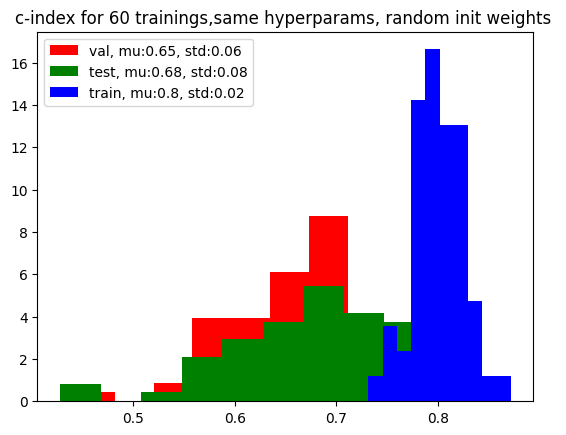

In [25]:
import matplotlib.pyplot as plt 
nbins = 10

plt.clf
plt.title("c-index for 60 trainings,same hyperparams, random init weights ")
plt.hist(ctrain[2],color = "red",label = f"val, mu:{round(np.mean(ctrain[2]),2)}, std:{round(np.std(ctrain[2]),2)}",bins = nbins,density=True)
plt.hist(ctrain[1],color = "green",label = f"test, mu:{round(np.mean(ctrain[1]),2)}, std:{round(np.std(ctrain[1]),2)}",bins = nbins,density=True)
plt.hist(ctrain[0],color = "blue",label = f"train, mu:{round(np.mean(ctrain[0]),2)}, std:{round(np.std(ctrain[0]),2)}",bins = nbins,density=True)
plt.legend()
plt.show

In [22]:
print("$$%beta$$")


$$%beta$$


# kfold

In [58]:
import pandas as pd
f = "/nodes/bevog/work4/seibel/data/aggregation_kfold_dataframes/tcga_brca_trainable4.csv"
data_path = None
df = pd.read_csv(f)

criterion = Survival_Loss(alpha) 


outputvals = []
modelweightslist = []
for j in range(5):
    outputvals_k = []
    modelweightslist_k = []
    
    df.kfold = df.kfold.apply(lambda x: (x+1)%5)
    dataset_train  = Gen_Dataset(df,data_path,train="train",mode="kfold")
    dataset_val  = Gen_Dataset(df,data_path,train="test",mode="kfold")

    trainloader = torch.utils.data.DataLoader(dataset_train,batch_size=batchsize,num_workers=num_workers,pin_memory=False)
    valloader = torch.utils.data.DataLoader(dataset_val,batch_size=batchsize,num_workers=num_workers,pin_memory=False)

    for i in range(1):
        model = SNN_Survival(d_gen,d_gen_out,bins,device,activation="SELU").to(device)
        optimizer = torch.optim.Adam(model.parameters(),lr=learningrate,betas=[0.9,0.999],weight_decay=1e-5,)
        
        c_train,c_val,modelweights = Uni_Trainer_sweep(run=None,model=model,optimizer=optimizer,criterion=criterion,trainloader=trainloader,
                        valloader=valloader,bins=bins,epochs=epochs,device=device,storepath=None,run_name=None,
                        l1_lambda=l1_lambda,modality=modality,testloader=None)

        outputvals_k.append([c_train,c_val])
        modelweightslist_k.append(modelweights)
    outputvals.append(outputvals_k)
    modelweightslist.append(modelweightslist_k)


In [64]:
outputvals = np.array(outputvals) # dim : n_folds,n-repeats,(c_train,c_val)
print(outputvals)

[[[0.75369115 0.58536585]]

 [[0.82601356 0.72899729]]

 [[0.8009057  0.39837398]]

 [[0.81111498 0.69647696]]

 [[0.77006351 0.72357724]]]


In [63]:
np.mean(outputvals,axis=0)

array([[0.79235778, 0.62655827]])

In [56]:
f = "/nodes/bevog/work4/seibel/data/aggregation_kfold_dataframes/tcga_brca_trainable4.csv"
data_path = None
df = pd.read_csv(f)
print(df.kfold.unique())
df.head(10)


[0 1 2 3 4]


,case_id,slide_id,site,kfold,is_female,oncotree_code,age,survival_months_discretized,survival_months,censorship,...,ZWINT_rnaseq,ZXDA_rnaseq,ZXDB_rnaseq,ZXDC_rnaseq,ZYG11A_rnaseq,ZYG11B_rnaseq,ZYX_rnaseq,ZZEF1_rnaseq,ZZZ3_rnaseq,TPTEP1_rnaseq
0,TCGA-3C-AALI,TCGA-3C-AALI-01Z-00-DX1.F6E9A5DF-D8FB-45CF-B4B...,3C,0,1.0,IDC,50.0,3,131.57,1.0,...,0.153655,-0.207313,-0.427975,0.825128,0.825317,-0.963470,0.880672,0.164444,-1.064402,2.395788
1,TCGA-3C-AALI,TCGA-3C-AALI-01Z-00-DX2.CF4496E0-AB52-4F3E-BDF...,3C,0,1.0,IDC,50.0,3,131.57,1.0,...,0.153655,-0.207313,-0.427975,0.825128,0.825317,-0.963470,0.880672,0.164444,-1.064402,2.395788
2,TCGA-3C-AALJ,TCGA-3C-AALJ-01Z-00-DX1.777C0957-255A-42F0-9EE...,3C,1,1.0,IDC,62.0,2,48.42,1.0,...,2.665836,-1.099110,-0.184212,-1.279398,2.112450,-1.190473,0.856429,-0.579342,-0.874345,-0.485389
3,TCGA-3C-AALJ,TCGA-3C-AALJ-01Z-00-DX2.62DFE56B-B84C-40F9-962...,3C,1,1.0,IDC,62.0,2,48.42,1.0,...,2.665836,-1.099110,-0.184212,-1.279398,2.112450,-1.190473,0.856429,-0.579342,-0.874345,-0.485389
4,TCGA-3C-AALK,TCGA-3C-AALK-01Z-00-DX1.4E6EB156-BB19-410F-878...,3C,2,1.0,IDC,52.0,2,47.57,1.0,...,-0.322065,-0.381861,-0.459009,-0.931029,0.602789,-0.951448,0.979160,-0.899523,-0.520568,-0.384345
5,TCGA-4H-AAAK,TCGA-4H-AAAK-01Z-00-DX1.ABF1B042-1970-4E28-867...,4H,3,1.0,ILC,50.0,0,11.43,1.0,...,-0.312681,-0.604004,-0.497498,-0.249751,-0.954992,-0.416046,0.108680,-0.798999,-0.186249,0.005573
6,TCGA-5L-AAT0,TCGA-5L-AAT0-01Z-00-DX1.5E171263-30BF-4C6B-88A...,5L,4,1.0,ILC,42.0,2,48.52,1.0,...,-0.686021,0.114193,0.128381,-0.008212,-0.937623,-0.890623,0.156314,-0.620393,0.146596,-0.324757
7,TCGA-5L-AAT1,TCGA-5L-AAT1-01Z-00-DX1.F3449A5B-2AC4-4ED7-BF4...,5L,0,1.0,ILC,63.0,2,48.32,1.0,...,-0.533083,-0.753901,-0.087036,-0.474020,-0.571352,-1.250051,0.307265,0.348286,-0.764674,-0.412675
8,TCGA-5T-A9QA,TCGA-5T-A9QA-01Z-00-DX1.B4212117-E0A7-4EF2-B32...,5T,1,1.0,IDC,52.0,0,9.95,1.0,...,1.313579,-1.339552,-0.891924,-1.129803,-1.070377,-1.859903,-0.324003,-0.238588,-1.001213,-0.587850
9,TCGA-A1-A0SB,TCGA-A1-A0SB-01Z-00-DX1.B34C267B-CAAA-4AB6-AD5...,A1,2,1.0,ACBC,70.0,0,8.51,1.0,...,-0.879285,1.110662,-0.225821,1.091915,-0.903592,1.456168,1.240531,1.377000,0.838819,1.185807


In [57]:
for i in range(5):
    for j in range(5):
        if i!=j:
            list_a = list(df[df.kfold==i].case_id)
            list_b = list(df[df.kfold==j].case_id)
            print(i,j,len(list_a))
            for id in list_a:
                if id in list_b:
                    print(id)
                


0 1 206
0 2 206
0 3 206
0 4 206
1 0 206
1 2 206
1 3 206
1 4 206
2 0 208
2 1 208
2 3 208
2 4 208
3 0 203
3 1 203
3 2 203
3 4 203
4 0 200
4 1 200
4 2 200
4 3 200


In [11]:
import numpy as np
import matplotlib.pyplot as plt 
cvals = [[[0.8239960459656493, 0.48894585068888174, 0.48001977017175335, 0.49791733418776035], [0.7955022859261089, 0.47196411406600447, 0.5248239219078216, 0.46395386094200575]], [[0.8311854785176368, 0.6738105443634805, 0.4659051891867146, 0.5910844406343764], [0.8149335042461144, 0.7389627089584226, 0.5306841852267264, 0.7021003000428633]], [[0.775030677634868, 0.5723384895359418, 0.514407126300959, 0.6151046405823476], [0.8049811389355996, 0.47179253867151955, 0.4764577557605781, 0.5555050045495905]], [[0.7871647652424627, 0.6055538024613443, 0.4177913652971441, 0.5932470810981382], [0.7740909203887356, 0.6102871568318081, 0.4722740039271245, 0.4234774376775008]], [[0.7780346820809249, 0.527189705271897, 0.48897109826589596, 0.34412619344126194], [0.7803005780346821, 0.5442092154420921, 0.5424739884393064, 0.40846824408468246]]]
cvals = np.asarray(cvals) # 5folds, 2 repetitions, (c_train_c_val;c_train_rand,c_val_rand)

In [13]:
np.mean(cvals,axis=(0,1)) 

array([0.79652201, 0.57050541, 0.49138084, 0.51949845])

20971